### ライブラリのimport

In [797]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import pandas as pd
from pandas_profiling import ProfileReport
%matplotlib inline
from preprocessing.initial_preprocessing import initial_preprocessing
from preprocessing.drop_emergency_suspicious_height_weight import drop_emergency_suspicious_height_weight
from preprocessing.calculate_bmi_bmr_category import calculate_bmi_bmr_category
from preprocessing.remove_duplicate_ctdi import remove_duplicate_ctdi
from preprocessing.rename_and_drop_order import rename_and_drop_order_one_scan_ctdi
from preprocessing.remove_not_use_head_rest import remove_not_use_head_rest
from preprocessing.special_scan_exclude import special_scan_exclude

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 解析用の元データを読み込み

In [798]:
df = pd.read_excel('train_data.xlsx')

## データを前処理
* カラム名の変更
* 複数回スキャンについては,Mean CTDIvolが最大のみ残す
* 救急科などの怪しい身長と体重のデータを削除する

In [799]:
initial_preprocessing(df)
df = remove_duplicate_ctdi(df)
df.reset_index(drop=True, inplace=True)
# df_allで後で、身長体重を代入する分を分けられるようにしておく
df_all = df
df = drop_emergency_suspicious_height_weight(df)

正常に処理が行われました。


### 身長・体重の最終確認: この部分は自分で確認しないと危険

In [800]:
index = df['height_cm'].sort_values(ascending=True)[:30].index.to_list()

In [801]:
df[['scanning length', 'height_cm', 'weight_kg', 'id', 'study_date', 'target region', 'Mean CTDIvol']].loc[index]

,scanning length,height_cm,weight_kg,id,study_date,target region,Mean CTDIvol
2220,852.06,101.0,39.8,75206,2021-04-21,Chest,6.45
994,796.77,101.0,39.8,75206,2021-05-18,Chest,7.38
96,626.53,101.0,39.8,75206,2021-01-14,Abdomen,12.78
607,827.20,101.0,39.8,75206,2021-03-29,Chest,6.13
1179,796.77,101.0,39.8,75206,2021-06-18,Chest,6.70
2341,621.51,101.0,39.8,75206,2021-06-02,Abdomen,17.10
260,567.16,101.0,39.8,75206,2021-02-04,Chest,6.03
6360,506.63,117.7,76.4,9326611,2023-02-10,Bronchus,10.38
105,456.72,117.7,76.4,9326611,2021-01-15,Chest,9.14
3494,531.81,117.7,76.4,9326611,2022-01-21,Bronchus,9.90


In [802]:
# 最終的な怪しいデータに関しては直接データを確認して削除する
drop_ids = [75206, 9326611, 17049]
for ids in drop_ids:
    df = df[~(df['id'] == ids)]
df.reset_index(drop=True, inplace=True)

### 身長体重予測、線量予測、異常検知でも使用しない項目を削除する

In [803]:
unuse_cols = ['hospital_ward', 'modality', 'adult_child', 'department', 'preset_name']
df.drop(labels=unuse_cols, axis=1, inplace=True)

In [804]:
df.to_excel('preprocess_all_scan_data.xlsx')

In [805]:
df = df[~((df['CTDIw phantom type'] == 'IEC Head Dosimetry Phantom') & (df['scan_area'] == '頸部CT'))]
df = df[~((df['CTDIw phantom type'] == 'IEC Head Dosimetry Phantom') & (df['scan_area'] == '頸部〜骨盤CT'))]
df = df[~((df['CTDIw phantom type'] == 'IEC Head Dosimetry Phantom') & (df['scan_area'] == '胸部〜骨盤CT'))]
df = df[~((df['CTDIw phantom type'] == 'IEC Head Dosimetry Phantom') & (df['scan_area'] == '胸部CT'))]

* データに含まれている外れ値のデータはさらに削除しても良いかも

In [806]:
# 外れ値として取り扱うデータを追加
drop_accession_list = [1249030520220420, 1351460220230315, 1346485720230228, 1348835920230307,
                       1229782420220221]
for accession in drop_accession_list:
    df = df[~(df['accession'] == accession)]
df.reset_index(drop=True, inplace=True)

In [807]:
# 不適切な心臓関係のデータを取り除く
# 1.　管電圧が100kV, 2.肺静脈(カルト)で管電圧が140kVのもの,その他排除すべきデータ
#differenceが10以上のデータを確認した中で、以下のようなデータを削除 
# *脳でHead restを使用せずベッドで撮影したデータ 
# *オーダーに対して不適切な部位が撮影範囲に含まれている（脳CTで肩が含まれている等） 
# *腕を挙上していない（体幹部撮影の際） *上肢撮影で体幹が含まれている *金属等が装着されている *オーダーと撮影部位が異なる
unuse_accession = [1348557720230306, 1106913420210113, 1112271520210127, 1116921520210210, 1130557720210324,
                   1163646020210707, 1175490820210818, 1216316120220114, 1150306520210521, 1273513820220714, 
                   1301969120221017, 1283505320220817, 1315170020221125, 1184192220210917, 1293945820220920,
                   1257936320220523, 1190750720211013, 1219548120220124, 1364809020230425, 1117860420210215,
                   1249639320220422, 1335762120230126, 1291697020220912, 1359568020230411, 1190377920211012,
                   1262435120220608, 1347736320230303, 1289845120220906, 1223184520220202, 1330730720230113,
                   1327520120230104, 1197756320211109, 1129424720210322, 1309065120221107, 1343513920230218,
                   1198504120211111, 1208625320211216, 1358077220230406, 1130613820210324, 1223603420220203,
                   1197519820211108, 1105253820210108, 1140475720210420, 1335584020230126, 1293219420220916,
                   1144301520210430, 1111324820210125, 1338397620230204, 1164256820210709, 1323580920221220]
for accession in unuse_accession:
    df = df[~(df['accession'] == accession)]
df.reset_index(drop=True, inplace=True)

### スキャンオーダーの名前を変更する

In [808]:
rename_and_drop_order_one_scan_ctdi(df)

### ヘッドレストを使っていない撮影を削除する

In [809]:
df_brain = pd.read_excel('brain_check_head_rest.xlsx')
df_inner = pd.read_excel('orbit_inner_ear.xlsx')
df = remove_not_use_head_rest(df, df_brain, df_inner)

### 特殊な四肢系の特殊なスキャンや本来用いない管電圧を取り除く

In [810]:
df = special_scan_exclude(df)

### 前処理が終了したデータを保存する。

In [811]:
df.to_excel('preprocessed_train_data.xlsx', index=False)

In [796]:
df[df['scan_method'] == 'Dual Energy']['kV'].unique()

array([140, 100])

<AxesSubplot:>

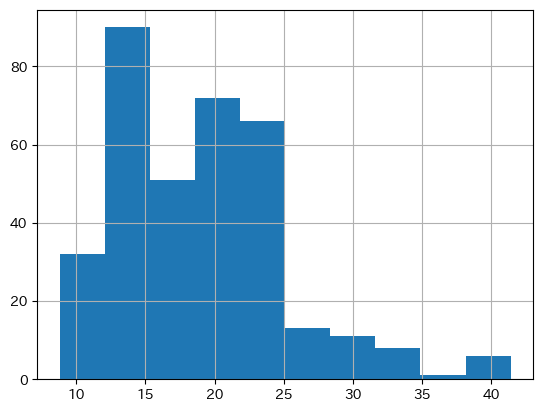

In [788]:
scan_area_list = df['scan_area'].unique()
for scan_area in scan_area_list:
    print(f'{scan_area}:',  df[df['scan_area'] == scan_area]['kV'].value_counts())

胸部CT: 100    2442
Name: kV, dtype: int64
胸部〜骨盤CT: 100    1749
Name: kV, dtype: int64
腹部〜骨盤CT: 100    1219
Name: kV, dtype: int64
副鼻腔CT: 100    333
Name: kV, dtype: int64
胸腰椎CT: 100    200
Name: kV, dtype: int64
大腿・膝・下腿CT: 100    83
Name: kV, dtype: int64
上腹部CT: 100    212
Name: kV, dtype: int64
体幹部Dual Energy CT: 140    350
Name: kV, dtype: int64
足・足関節CT: 100    58
Name: kV, dtype: int64
肩・上腕・鎖骨CT: 100    57
Name: kV, dtype: int64
頸部〜骨盤CT: 100    147
Name: kV, dtype: int64
肘・前腕・手関節CT: 100    68
Name: kV, dtype: int64
頸椎・頚髄CT: 100    76
Name: kV, dtype: int64
頸部CT: 100    67
Name: kV, dtype: int64
骨盤骨CT: 100    25
Name: kV, dtype: int64
顔面骨CT: 100    33
Name: kV, dtype: int64
冠動脈CT: 120    292
140     15
Name: kV, dtype: int64
肺静脈CT: 120    105
Name: kV, dtype: int64
肺塞栓CT: 140    53
100    36
Name: kV, dtype: int64
歯・顎骨CT: 140    199
Name: kV, dtype: int64
脳Perfusion: 80    5
Name: kV, dtype: int64
脳CTA: 100    23
Name: kV, dtype: int64
脳CT: 100    671
Name: kV, dtype: int64
側頭骨CT: 100

<AxesSubplot:>

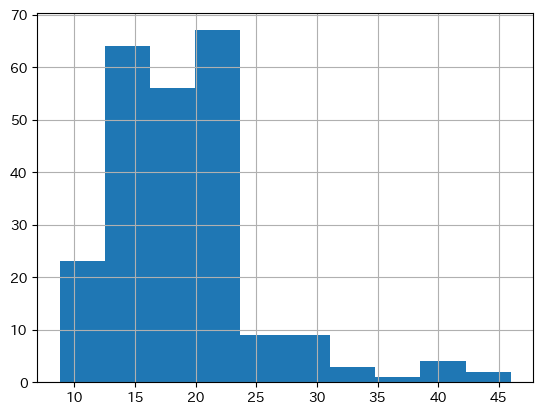

In [747]:
# 体幹部系のdual energy ctはまとめることはできないのか？
df_test = df[df['scan_area'] == '胸部〜骨盤CT']
df_test[df_test['scan protocol'].str.contains('GSIX')]['Mean CTDIvol'].hist()

<AxesSubplot:>

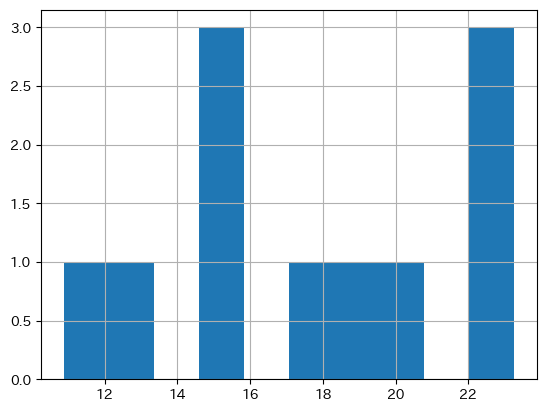

In [749]:
# 体幹部系のdual energy ctはまとめることはできないのか？
df_test = df[df['scan_area'] == '頸部〜骨盤CT']
df_test[df_test['scan protocol'].str.contains('GSIX')]['Mean CTDIvol'].hist()

<AxesSubplot:>

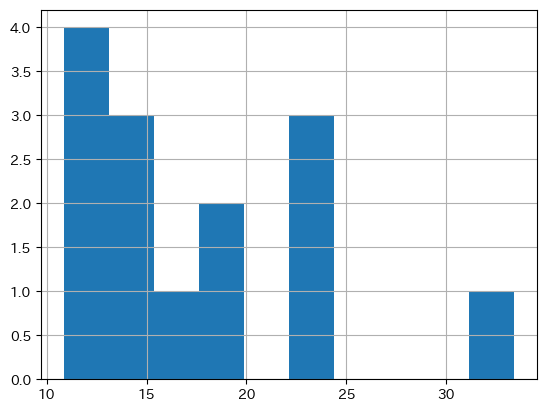

In [750]:
# 体幹部系のdual energy ctはまとめることはできないのか？
df_test = df[df['scan_area'] == '胸部CT']
df_test[df_test['scan protocol'].str.contains('GSIX')]['Mean CTDIvol'].hist()

<AxesSubplot:>

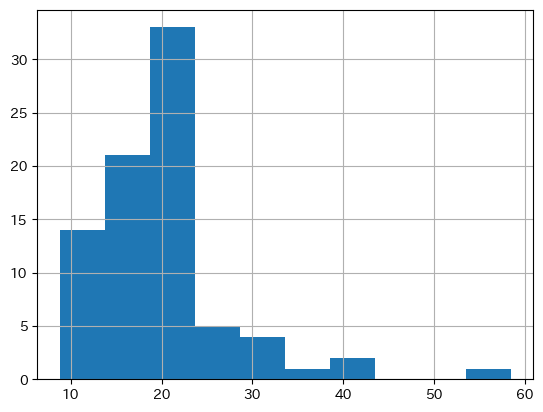

In [751]:
# 体幹部系のdual energy ctはまとめることはできないのか？
df_test = df[df['scan_area'] == '腹部〜骨盤CT']
df_test[df_test['scan protocol'].str.contains('GSIX')]['Mean CTDIvol'].hist()

<AxesSubplot:>

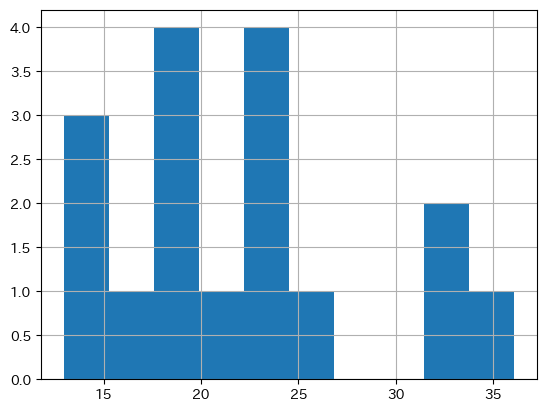

In [752]:
# 体幹部系のdual energy ctはまとめることはできないのか？
df_test = df[df['scan_area'] == '上腹部CT']
df_test[df_test['scan protocol'].str.contains('GSIX')]['Mean CTDIvol'].hist()

In [757]:
# Define the conditions for the change
scan_areas_to_change = ['胸部CT', '胸部〜骨盤CT', '腹部〜骨盤CT', '上腹部CT', '頸部〜骨盤CT']
kV_value_to_change = 140
protocol_to_change = 'GSIX'

# Make the change in the dataframe
df.loc[(df['scan_area'].isin(scan_areas_to_change)) & (df['kV'] == kV_value_to_change) & df['scan protocol'].str.contains(protocol_to_change, na=False), 'scan_area'] = '体幹部Dual Energy CT'

# Display the first few rows of the modified dataframe
df.head()

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,...,Mean CTDIvol,DLP,study_date,id,age,gender,height_cm,weight_kg,scan_area,scan_method
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80.0,...,5.86,223.82,2021-01-01,12585,86,F,150.0,49.1,胸部CT,単純
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80.0,...,7.41,327.55,2021-01-01,2145609,61,M,163.0,74.0,胸部CT,単純
2,1103339220210102,5.1 QQ Chest Routine,NaN,Chest,467.06,100,306.59,700,1.38,80.0,...,5.13,239.47,2021-01-02,12615,46,M,178.0,68.0,胸部CT,単純
3,1103327120210102,5.1 QQ Chest Routine,NaN,Chest,472.12,100,433.42,700,1.38,80.0,...,7.25,342.20,2021-01-02,12616,52,M,182.0,70.0,胸部CT,単純
4,1103481920210103,5.1 QQ Chest Routine,NaN,Chest,462.22,100,691.26,700,1.38,80.0,...,11.56,534.33,2021-01-03,9595120,52,M,175.0,112.0,胸部CT,単純


In [654]:
df[df['scan_area'] == '顔面骨CT']['kV'].value_counts()

100    33
140     5
120     1
Name: kV, dtype: int64

In [655]:
df[df['scan_area'] == '脳CT']['kV'].value_counts()

100    671
Name: kV, dtype: int64

In [656]:
df[df['scan_area'] == '副鼻腔CT']['kV'].value_counts()

100    333
120     18
140      1
Name: kV, dtype: int64

In [658]:
df[df['scan_area'] == '胸椎・胸髄CT']['kV'].value_counts()

100    8
Name: kV, dtype: int64

In [659]:
df[df['scan_area'] == '腰椎・腰髄CT']['kV'].value_counts()

100    192
140      4
120      1
Name: kV, dtype: int64